# ResNet50 /  Classify Multi-label Emotions

In [1]:
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 382.6 MB 35 kB/s 


In [2]:
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-tf-plugin-cuda110

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 418 kB 753 kB/s 
  Created wheel for nvidia-dali-tf-plugin-cuda110: filename=nvidia_dali_tf_plugin_cuda110-1.19.0-cp37-cp37m-linux_x86_64.whl size=120498 sha256=e05349b7d1ab9f8262534aa0109a76937fda47aa203f10b13e64958b9363db3f
  Stored in directory: /root/.cache/pip/wheels/7f/8c/08/7adf9f8b758908640a1a1569489d8ab08a81a05192aa508363
Successfully built nvidia-dali-tf-plugin-cuda110


In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os

In [4]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
# Record cell run time.
!pip install ipython-autotime

%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 15.3 MB/s 
time: 395 µs (started: 2022-11-21 12:08:36 +00:00)


In [6]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 1.24 ms (started: 2022-11-21 12:08:36 +00:00)


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 4min 16s (started: 2022-11-21 12:08:36 +00:00)


### Load label data.

In [8]:
# Load labels, check headers, check data shape.
f_PATH = "/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/"

df_label = pd.read_csv(f_PATH+'label/label_multi-label.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print("All classes:", len(LABELS))

label_valid = pd.read_csv(f_PATH+'label/label_multi-label_valid.csv')
label_train = pd.read_csv(f_PATH+'label/label_multi-label_train.csv')
label_test = pd.read_csv(f_PATH+'label/label_multi-label_test.csv')

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", label_train.shape[0])
print("VALID_DATA_SIZE:", label_valid.shape[0])
print("TEST_DATA_SIZE:", label_test.shape[0])

Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
       'happy', 'disgusted'],
      dtype='object')
(38817, 26)
LABELS= ['moved', 'fearful', 'bored', 'surprised', 'angry', 'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled', 'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed', 'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful', 'happy', 'disgusted']
All classes: 24
TRAIN_DATA_SIZE: 31053
VALID_DATA_SIZE: 3882
TEST_DATA_SIZE: 3882
time: 3.96 s (started: 2022-11-21 12:12:53 +00:00)


### Define training pipeline.

In [9]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.plugin.tf as dali_tf

class TFRecordPipelineTrain(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTrain, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = [f_PATH+'tfrecords/multi-label_train.tfrecords'],
             index_path = [f_PATH+'tfrecords/multi-label_train.idx'],
             random_shuffle=True,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 126 ms (started: 2022-11-21 12:12:56 +00:00)


### Define validation pipeline.

In [10]:
class TFRecordPipelineValid(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineValid, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = [f_PATH+'tfrecords/multi-label_valid.tfrecords'],
             index_path = [f_PATH+'tfrecords/multi-label_valid.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.78 ms (started: 2022-11-21 12:12:57 +00:00)


### Fine-tune ResNet50 model for classifying multi-label emotions.

In [11]:
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://keras.io/guides/transfer_learning/

if __name__ == "__main__":
    batch_size = 64
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 24))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)

    batch_size_valid = 64
    shapes_valid = ((batch_size_valid, 64, 64, 3),
                    (batch_size_valid, 24))
    pipe_valid = TFRecordPipelineValid(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)       

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        
        ds_valid = dali_tf.DALIDataset(
            pipeline=pipe_valid,
            batch_size=batch_size_valid,
            output_shapes=shapes_valid,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)      

        initializer = keras.initializers.GlorotUniform(seed=set_seed)
        activation =  keras.activations.sigmoid         
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // batch_size * 10,
            decay_rate=0.95)
        
        number_of_classes = 24
        
        base_model = keras.applications.ResNet50(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            input_shape=(64, 64, 3), # VGG16 expects min 32 x 32
            include_top=False, # Do not include the ImageNet classifier at the top.
            pooling='avg') # average pooling added 
        
        base_model.trainable = True   # Unfreeze ResNet50 weights.

        # See how many layers are in the base model.
        print("Number of layers in the base model: ", len(base_model.layers))
        
        # Fine-tune from this layer onwards.
        fine_tune_at = 120
        
        # Freeze all the layers before the `fine_tune_at` layer.
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable =  False   
            
        inputs = keras.Input(shape=(64, 64, 3))
        x = base_model(inputs)
        fc1 = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer)(x)        
        do1 = keras.layers.Dropout(0.5, seed=set_seed)(fc1)          
        outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(do1)   
        clf = keras.Model(inputs, outputs)
        
        clf.summary()

        # Apply early stopping.        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)  
        
        clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
        
        history = clf.fit(ds_train, steps_per_epoch=TRAIN_DATA_SIZE // batch_size, 
                          validation_data=ds_valid.take(VALID_DATA_SIZE // batch_size_valid),
                          epochs=1000,
                          )#callbacks=[es_callback])

94765736/94765736 [==============================] - 3s 0us/step
Number of layers in the base model:  176
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 24)                49176     
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
Total params: 23,637,488
Trainable params: 17,265,264
Non-trainable params: 6,372,224
_

In [12]:
from keras.models import load_model
clf.save('/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/model/resnet_multi.h5')

time: 1.1 s (started: 2022-11-21 18:33:58 +00:00)


In [13]:
# List all data in history.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 1.21 ms (started: 2022-11-21 18:33:59 +00:00)


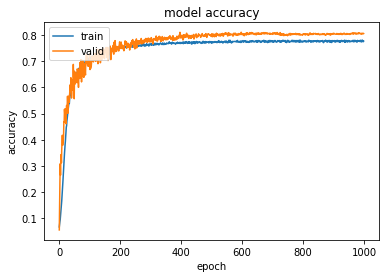

time: 386 ms (started: 2022-11-21 18:33:59 +00:00)


In [14]:
# Summarize history for accuracy.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

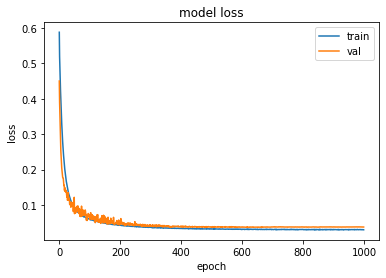

time: 131 ms (started: 2022-11-21 18:34:00 +00:00)


In [15]:
# Summarize history for loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Define test pipeline.

In [16]:
class TFRecordPipelineTest(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTest, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = [f_PATH+'tfrecords/multi-label_test.tfrecords'],
             index_path = [f_PATH+'tfrecords/multi-label_test.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.92 ms (started: 2022-11-21 18:34:00 +00:00)


### Check test data accuracy.

In [17]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 24))
    pipe_test = TFRecordPipelineTest(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_test = dali_tf.DALIDataset(
            pipeline=pipe_test,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        print(ds_test)
        loss, acc = clf.evaluate(ds_test, steps=TEST_DATA_SIZE)
        print("Test accuracy:", acc)
        predictions = clf.predict(ds_test.take(5))
        print("A test output from the last layer:", predictions[0])
        print("Index of the maximum value:", np.argmax(predictions[0]))
        print("Label:", LABELS[np.argmax(predictions[0])])

<DALIDataset element_spec=(TensorSpec(shape=(1, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 24), dtype=tf.int64, name=None))>
3882/3882 [==============================] - 40s 10ms/step - loss: 0.0328 - accuracy: 0.8027
Test accuracy: 0.8026790022850037
5/5 [==============================] - 1s 8ms/step
A test output from the last layer: [4.4645934e-14 6.4299582e-18 7.2767327e-19 2.7179981e-14 1.5720536e-08
 3.1689915e-12 1.2994536e-15 6.1521083e-16 3.4007172e-10 1.4436727e-13
 5.5984453e-14 4.7156705e-09 9.9981755e-01 6.7646357e-12 6.7625747e-15
 5.3575162e-09 3.2226907e-13 1.5518643e-15 9.3214221e-11 1.7766091e-16
 3.0811307e-13 3.8786361e-16 4.5595822e-15 1.5176496e-17]
Index of the maximum value: 12
Label: upset
time: 41.3 s (started: 2022-11-21 18:34:00 +00:00)


In [18]:
predictions

array([[4.46459344e-14, 6.42995821e-18, 7.27673266e-19, 2.71799812e-14,
        1.57205360e-08, 3.16899154e-12, 1.29945357e-15, 6.15210829e-16,
        3.40071721e-10, 1.44367266e-13, 5.59844529e-14, 4.71567052e-09,
        9.99817550e-01, 6.76463573e-12, 6.76257468e-15, 5.35751621e-09,
        3.22269067e-13, 1.55186431e-15, 9.32142211e-11, 1.77660912e-16,
        3.08113073e-13, 3.87863613e-16, 4.55958217e-15, 1.51764961e-17],
       [1.52161007e-03, 1.10060675e-03, 3.91211552e-06, 8.90832569e-04,
        2.46785021e-05, 6.36908948e-01, 2.02319443e-05, 7.22481753e-04,
        1.19213779e-02, 7.90327496e-04, 1.45918802e-05, 1.26512081e-04,
        1.45202801e-02, 6.75062474e-05, 2.50650267e-03, 1.49392290e-04,
        1.05200394e-04, 4.65479243e-04, 5.79919215e-05, 3.21996663e-06,
        4.56137604e-05, 2.17836696e-05, 2.51420570e-05, 9.77333639e-06],
       [5.34899014e-09, 6.50881127e-09, 6.38563924e-11, 2.03623229e-12,
        4.72095572e-08, 6.09824610e-07, 2.43103782e-09, 7.5629

time: 7.05 ms (started: 2022-11-21 18:34:41 +00:00)


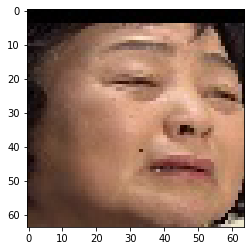

time: 169 ms (started: 2022-11-21 18:34:41 +00:00)


In [19]:
# Display the tested image.

import matplotlib.pyplot as plt

data, = ds_test.take(1)
plt.imshow(data[0][0])

In [20]:
# Check the test data's true label.
data[1]

<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])>

time: 5.3 ms (started: 2022-11-21 18:34:41 +00:00)


### Result: Argmax Accuracy & Micro F1-score

In [21]:
pred_test = clf.predict(ds_test.take(TEST_DATA_SIZE))

3882/3882 [==============================] - 31s 8ms/step
time: 32 s (started: 2022-11-21 18:34:41 +00:00)


In [22]:
true_test = np.concatenate([y for x, y in ds_test.take(TEST_DATA_SIZE)], axis=0)

time: 2.04 s (started: 2022-11-21 18:35:13 +00:00)


In [23]:
true_test.shape

(3882, 24)

time: 5.16 ms (started: 2022-11-21 18:35:15 +00:00)


In [24]:
from sklearn.metrics import accuracy_score, f1_score

true_test_ls = []
pred_test_ls = []

for (true, pred) in zip(true_test, pred_test):
    true_test_ls.append(np.argmax(true))
    pred_test_ls.append(np.argmax(pred))

argmax_acc = accuracy_score(true_test_ls, pred_test_ls)
f1_micro = f1_score(true_test_ls, pred_test_ls, average='micro')

print("argmax accuracy:", argmax_acc)
print("f1_micro:", f1_micro)

argmax accuracy: 0.8026790314270994
f1_micro: 0.8026790314270994
time: 453 ms (started: 2022-11-21 18:35:15 +00:00)


### Result: Threshold=0.5 Accuracy & Micro F1-score

In [25]:
pred_05 = pred_test.copy()
pred_05

array([[4.46459344e-14, 6.42995821e-18, 7.27673266e-19, ...,
        3.87863613e-16, 4.55958217e-15, 1.51764961e-17],
       [1.52161007e-03, 1.10060675e-03, 3.91211552e-06, ...,
        2.17836696e-05, 2.51420570e-05, 9.77333639e-06],
       [5.34899014e-09, 6.50881127e-09, 6.38563924e-11, ...,
        1.34059983e-12, 9.53935628e-12, 2.46846737e-10],
       ...,
       [6.35501749e-07, 6.98004499e-09, 2.91739679e-12, ...,
        4.58335175e-11, 2.82825163e-09, 4.06001057e-12],
       [8.45678585e-07, 8.88226449e-01, 3.30598873e-08, ...,
        1.75967699e-07, 1.03054973e-07, 6.87375859e-07],
       [1.38884939e-08, 2.03471053e-08, 1.09702754e-10, ...,
        4.64333105e-09, 8.36090948e-08, 2.81042674e-08]], dtype=float32)

time: 4.74 ms (started: 2022-11-21 18:35:16 +00:00)


In [26]:
for ls in pred_05:
    thres = 0.5
    pred_05[pred_05 >= thres] = 1
    pred_05[pred_05 < thres] = 0
pred_05[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.3 s (started: 2022-11-21 18:35:16 +00:00)


In [27]:
accuracy_score(true_test, pred_05)

0.8608964451313755

time: 15.2 ms (started: 2022-11-21 18:35:17 +00:00)


In [28]:
f1_score(true_test, pred_05, average='micro')

0.9325660852364682

time: 21.4 ms (started: 2022-11-21 18:35:17 +00:00)


### Result: Threshold=0.4 Accuracy & Micro F1-score

In [29]:
pred_04 = pred_test.copy()
for ls in pred_04:
    thres = 0.4
    pred_04[pred_04 >= thres] = 1
    pred_04[pred_04 < thres] = 0
pred_04[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.29 s (started: 2022-11-21 18:35:17 +00:00)


In [30]:
accuracy_score(true_test, pred_04)

0.8753219989696033

time: 10.9 ms (started: 2022-11-21 18:35:18 +00:00)


In [31]:
f1_score(true_test, pred_04, average='micro')

0.9376949817274267

time: 16 ms (started: 2022-11-21 18:35:18 +00:00)


### Result: Threshold=0.3 Accuracy & Micro F1-score

In [32]:
pred_03 = pred_test.copy()
for ls in pred_03:
    thres = 0.3
    pred_03[pred_03 >= thres] = 1
    pred_03[pred_03 < thres] = 0
pred_03[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.29 s (started: 2022-11-21 18:35:19 +00:00)


In [33]:
accuracy_score(true_test, pred_03)

0.8884595569294178

time: 17.7 ms (started: 2022-11-21 18:35:20 +00:00)


In [34]:
f1_score(true_test, pred_03, average='micro')

0.9432461103253182

time: 21.5 ms (started: 2022-11-21 18:35:20 +00:00)


### Result: Threshold=0.2 Accuracy & Micro F1-score

In [35]:
pred_02 = pred_test.copy()
for ls in pred_02:
    thres = 0.2
    pred_02[pred_02 >= thres] = 1
    pred_02[pred_02 < thres] = 0
pred_02[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.31 s (started: 2022-11-21 18:35:20 +00:00)


In [36]:
accuracy_score(true_test, pred_02)

0.8972179289026275

time: 11.7 ms (started: 2022-11-21 18:35:21 +00:00)


In [37]:
f1_score(true_test, pred_02, average='micro')

0.9460311897669529

time: 19.1 ms (started: 2022-11-21 18:35:21 +00:00)


### Result: Threshold=0.1 Accuracy & Micro F1-score

In [38]:
pred_01 = pred_test.copy()
for ls in pred_01:
    thres = 0.1
    pred_01[pred_01 >= thres] = 1
    pred_01[pred_01 < thres] = 0
pred_01[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.32 s (started: 2022-11-21 18:35:21 +00:00)


In [39]:
accuracy_score(true_test, pred_01)

0.9041731066460588

time: 13.7 ms (started: 2022-11-21 18:35:23 +00:00)


In [40]:
f1_score(true_test, pred_01, average='micro')

0.9458831626946571

time: 17.4 ms (started: 2022-11-21 18:35:23 +00:00)


time: 25.6 ms (started: 2022-11-21 18:35:23 +00:00)
